In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

In [2]:
# Load transaction data
transaction_chunks = pd.read_csv('train_transaction.csv', chunksize=50000)
transaction = pd.concat([chunk for chunk in transaction_chunks])

# Load identity data
identity_chunks = pd.read_csv('train_identity.csv', chunksize=50000)
identity = pd.concat([chunk for chunk in identity_chunks])

# Merge the transaction and identity data on the common column "TransactionID"
data = pd.merge(transaction, identity, on='TransactionID', how='left')
data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Load transaction data
transaction_chunks = pd.read_csv('train_transaction.csv', chunksize=50000)
transaction = pd.concat([chunk for chunk in transaction_chunks])

# Load identity data
identity_chunks = pd.read_csv('train_identity.csv', chunksize=50000)
identity = pd.concat([chunk for chunk in identity_chunks])

# Merge the transaction and identity data on the common column "TransactionID"
data = pd.merge(transaction, identity, on='TransactionID', how='left')

# Drop the columns with more than 50% missing values
data.dropna(thresh=len(data) // 2, axis=1, inplace=True)

# Label encode the categorical features
categorical_features = data.select_dtypes(include='object').columns
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

df.drop(['TransactionID'], inplace=True, axis = 1)

In [ ]:
# Split the data into training and testing sets
X = data.drop(['isFraud', 'TransactionID'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.fillna(0), y_train)

In [8]:
# Train a random forest classifier on the resampled training data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [9]:
# Make predictions on the testing data
y_pred = model.predict(X_test.fillna(0))

# Calculate the accuracy and other performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9785958614149761
Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.91      0.45      0.60      4242

    accuracy                           0.98    118108
   macro avg       0.94      0.72      0.80    118108
weighted avg       0.98      0.98      0.98    118108

Confusion matrix:


NameError: name 'confusion_matrix' is not defined

In [10]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion matrix:
[[113668    198]
 [  2330   1912]]


F1-score:  0.602015113350126
Precision:  0.9061611374407583
Recall:  0.4507307873644507
Specificity:  0.9982611139409482
Sensitivity:  0.4507307873644507
AUC:  0.9185898009532417


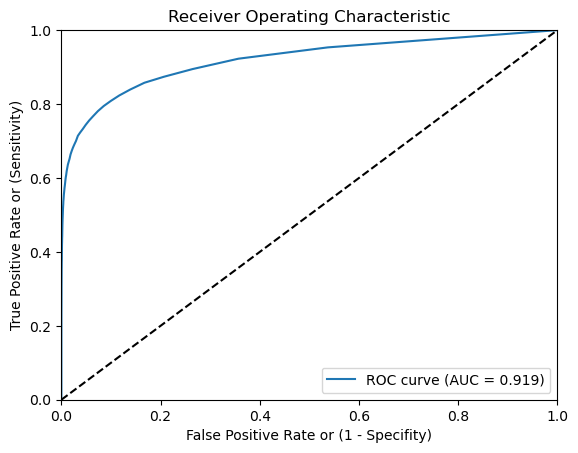

Accuracy: 0.978596


In [12]:
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall

#predict the class probabilities
y_pred_proba = model.predict_proba(X_test.fillna(0))[:, 1]
#calculate the AUC value
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred_proba)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

In [3]:
#Confusion matrix:
#[[113668    198]
# [  2330   1912]]

tp = 113668
fp = 198
fn = 2330
tn = 1912

import math
mcc = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
print("Matthews correlation coefficient:", mcc)

Matthews correlation coefficient: 0.6307458380911203
